# Проксимальный метод

In [10]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib
import cvxpy as cvx
from step_size import ConstantStepSize, SeqStepSize, StepSize

In [11]:
import sklearn.preprocessing as skprep

In [12]:
matplotlib.use('Agg')
params = {'legend.fontsize': 20,
          'legend.handlelength': 4,
          "axes.labelsize": 45,
          "xtick.labelsize": 25,
          "ytick.labelsize": 25,
          "lines.linewidth": 4,
           "axes.titlesize":30}
matplotlib.rcParams.update(params)

"Многие методы первого порядка (методы градиентного типа) основаны на использовании квадратичной функции (параболоида вращения) в качестве оптимизации модели. Однако необязательно рассматривать именно параболоиды вращения. Можно использовать и другие функции, которые позволяют построить более точную локальную модель целевой функции задачи в рассматриваемой точке, что приводит в итоге к увеличению скорости сходимости метода. Здесь можно выделить два направления. Первое направление связано с использованием старших производных в модели функции, а второе — с занесением в модель части постановки задачи. Например, если оптимизируемая функция есть сумма гладкой и негладкой функций, то первую можно заменять параболоидом вращения в модели, а вторую оставить как есть. Насколько нам известно, по такому подходу до последнего момента имелись лишь разрозненные результаты."
Источник: Р. Ф. Хильдебранд, Е. А. Воронцова, А. В. Гасников, Ф. С. Стонякин "Выпуклая оптимизация"

### Общее понятие проксимального оператора

Пусть $f : \mathbb{R}^n \to \mathbb{R}$ замкнутая выпуклая функция (не обязательно гладкая), т.е. её надграфик  

$$\text { epi } f=\left\{(x, t) \in \mathbf{R}^n \times \mathbf{R} \mid f(x) \leq t\right\}$$
является закрытым выпуклым множеством. (Почему это условие существенно?)  

$$\operatorname{dom} f=\left\{x \in \mathbf{R}^n \mid f(x)<+\infty\right\}$$
множество точек, на которых $f$ ограничена.  

Проксимальным оператором называется функция вида:
$$\operatorname{prox}_f(v)=\underset{x}{\operatorname{argmin}}\left(f(x)+(1 / 2)\|x-v\|_2^2\right)  \quad \quad (1)$$

### Проксимальный оператор для негладкой функции

Предположим, что функцию $f$ возможно представить как сумму $f(x) = \phi(x) + h(x)$, где $\phi(x)$ - выпуклая гладкая функция, а $h(x)$ - выпуклая негладкая функция. Определим аппроксимационную подзадачу:

$$
q_\lambda(x_k)=\underset{x}{\operatorname{argmin}}\left(\phi(x_k) + \nabla \phi(x_k)^\top(x - x_k) + h(x) + (1 / 2 \lambda)\|x-x_k\|_2^2\right)$$  

Можно показать, что для такой подзадачи проксимальный оператор примет вид:  
$$x_{k+1} := \operatorname{prox}_{\lambda^k h}(x_k - \lambda_k \nabla \phi(x_k ))  \quad \quad (2)$$
Подробнее см. N. Parikh and S. Boyd. "Proximal Algorithms." с. 148    

__Примечание__ Отсюда видим, что при $h(x)=0$ получаем обычный градиентный метод  
__Примечание__ При $\phi(x)=0$ получаем проксимальный метод (1)  
__Примечание__ Данный метод используют для ускорения обычного субградиентного метода, так как при постоянном шаге он не сходится вблизи изломов негладких функций

## Эксперимент LASSO

Решим задачу LASSO:

$$
\min_x f(x) = \frac{1}{2}\|Ax - y \|^2_2 + \gamma \|x\|_1
$$

**Проксимальный метод.** Чтобы составить проксимальный оператор, представим $f(x)$ как композитную задачу:  
- $\phi(x) = \frac{1}{2}\|Ax - y \|^2_2$
- $h(x) = \gamma \|x\|_1$

Результат:

$$ 
x_{k+1} = \begin{cases} x_i - \lambda & x_i \geq \lambda  \\ 0 & |x_i| \leq \lambda \\ x_i + \lambda & x_i \leq -\lambda \end{cases}
$$
Или в векторизованном виде:  
$$
x_{k+1} = \text{sign}(x)(|x| - \lambda)_+, \; |x| = (|x_1|, \ldots, |x_n|)
$$


**Субградиентный метод.** Сравним проксимальный метод с субградиентным методом c шагом вида $\alpha_k = \frac{\| x_0 - x^*\|}{\sqrt{k + 1}}$.

$$x_{k+1} = x_k - \alpha_k \frac{\nabla f(x_k)}{\| \nabla f(x_k) \|_2}$$


**Ускоренный проксимальный метод** ...

In [ ]:
class ProxGM:
    def __init__(self, fix_lam=None, lam0=1, beta=0.5, return_history=True, name=None):
        self.name = name
        self.return_history = return_history
        self.history = []
        self.lam0 = lam0
        self.fix_lam = fix_lam
        self.beta = beta

    def backtracking(self, x, f, gradf, g_prox):
        lam = self.lam0
        f_x = f(x)
        f_grad_x = gradf(x)
        z = g_prox(x - lam * f_grad_x, lam)
        while f(z) > f_x + np.sum(f_grad_x * (z - x)) + np.linalg.norm(z - x) ** 2 / (2 * lam):
            lam = lam * self.beta
            z = g_prox(x - lam * gradf(x), lam)
            self.lam0 = lam
            if lam <= 1e-9:
                break
        return z

    def solve(self, x0, f, gradf, g_prox, tol=1e-3, max_iter=10000):
        x = x0.copy()
        self.history = [(x, time.time())]
        for i in range(max_iter):
            if self.fix_lam is None:
                x = self.backtracking(x, f, gradf, g_prox)
            else:
                x_ = x - self.fix_lam * gradf(x)
                x = g_prox(x_, self.fix_lam)
            self.history.append((x, time.time()))
        return x

In [ ]:
class AccProxGM(ProxGM):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def solve(self, x0, f, gradf, g_prox, tol=1e-3, max_iter=10000):
        x = x0.copy()
        x_prev = x.copy()
        self.history = [(x, time.time())]
        t_prev = 1
        t_next = (1 + np.sqrt(1 + 4 * t_prev ** 2)) / 2.
        for i in range(max_iter):
            w = (t_prev - 1) / t_next
            x, x_prev = x + w * (x - x_prev), x
            t_prev = t_next
            t_next = (1 + np.sqrt(1 + 4 * t_prev ** 2)) / 2.
            if self.fix_lam is None:
                x = self.backtracking(x, f, gradf, g_prox)
            else:
                x_ = x - self.fix_lam * gradf(x)
                x = g_prox(x_, self.fix_lam)
            self.history.append((x, time.time()))
        return x

In [14]:
class SubgradMethod:
    def __init__(self, StepSizeChoice, return_history=True, name=None):
        self.name = name
        self.StepSizeChoice = StepSizeChoice
        self.return_history = return_history
        self.history = []
    
    def __call__(self, x0, f, gradf, N):
        assert True, 'Please call solve method.'
    
    def solve(self, x0, f, subgradf, tol=1e-9, max_iter=10000):
        self.history = [(x0, time.time())]
        x = x0.copy()
        k = 0
        x_prev = None
        while True: 
            h = -subgradf(x) / np.linalg.norm(subgradf(x))
            alpha = self.StepSizeChoice(x, h, k, subgradf, f)
            x_prev, x = x, x + alpha * h
            if self.return_history:
                self.history.append((x, time.time()))
            if k >= max_iter:
                break
            k += 1
        return x

In [15]:
m = 50
n = 250

A = np.random.rand(m, n)
A = skprep.normalize(A, norm="l2", axis=0) # нормировка строк матрицы

x_true = np.random.randn(n)
x_true[np.random.rand(n) < 0.96] = 0 # сделаем вектор разреженным
print("Number of nonzeros in x_true = {}".format(np.sum(x_true != 0)))

v = 9e-2 * np.random.randn(m)
y = A.dot(x_true) + v
gamma_max = np.linalg.norm(A.T.dot(y), ord=np.inf)
gamma = 0.1 * gamma_max

print("Gamma = {}".format(gamma))
print("S2N ratio = {}".format(np.linalg.norm(A.dot(x_true)) ** 2 / np.linalg.norm(v) ** 2))
x0 = np.random.rand(n)

L = np.linalg.eigvalsh(A.T.dot(A)).max()

Number of nonzeros in x_true = 11
Gamma = 0.07097491313424396
S2N ratio = 5.755502125419951


In [16]:
F_composite = lambda x: np.linalg.norm(A.dot(x) - y) ** 2 / 2 + gamma * np.sum(np.abs(x))
subgradF_composite = lambda x: A.T.dot(A.dot(x) - y) + gamma * np.sign(x) # субградиент

f = lambda x: np.linalg.norm(A.dot(x) - y) ** 2 / 2
gradf = lambda x: A.T.dot(A.dot(x) - y) # градиент дифференцируемой части

g_prox = lambda h, alpha: np.sign(h) * np.maximum(np.abs(h) - alpha * gamma, 0) # проксимальный оператор

Запуск методов

In [17]:
max_iters = 300
methods = []

method = SubgradMethod(ConstantStepSize(np.linalg.norm(x0 - x_true) / np.sqrt(max_iters + 1)), name="Subgradient Method, Descending Step Size")
x_subgrad = method.solve(x0, F_composite, subgradF_composite, max_iter=max_iters)
methods.append(method)
print(method.name)
print("\tNumber nonzeros in x* = {}".format(np.sum(x_subgrad != 0)))
print("\tf^* = {}".format(F_composite(x_subgrad)))

method = ProxGM(name="ProxGM")
x = method.solve(x0, f, gradf, g_prox, max_iter=max_iters)
methods.append(method)
print(method.name)
print("\tNumber nonzeros in x* = {}".format(np.sum(x != 0)))
print("\tf* = {}".format(F_composite(x)))

method = AccProxGM(fix_lam=None, name="AccProxGM")
x_acc = method.solve(x0, f, gradf, g_prox, max_iter=max_iters)
methods.append(method)
print(method.name)
print("\tNumber nonzeros in x* = {}".format(np.sum(x_acc != 0)))
print("\tf* = {}".format(F_composite(x_acc)))

Subgradient Method, Descending Step Size
	Number nonzeros in x* = 250
	f^* = 13.029050734102915
ProxGM
	Number nonzeros in x* = 220
	f* = 3.0736084763734346
AccProxGM
	Number nonzeros in x* = 37
	f* = 0.5806382448900493


Сравнение методов друг с другом

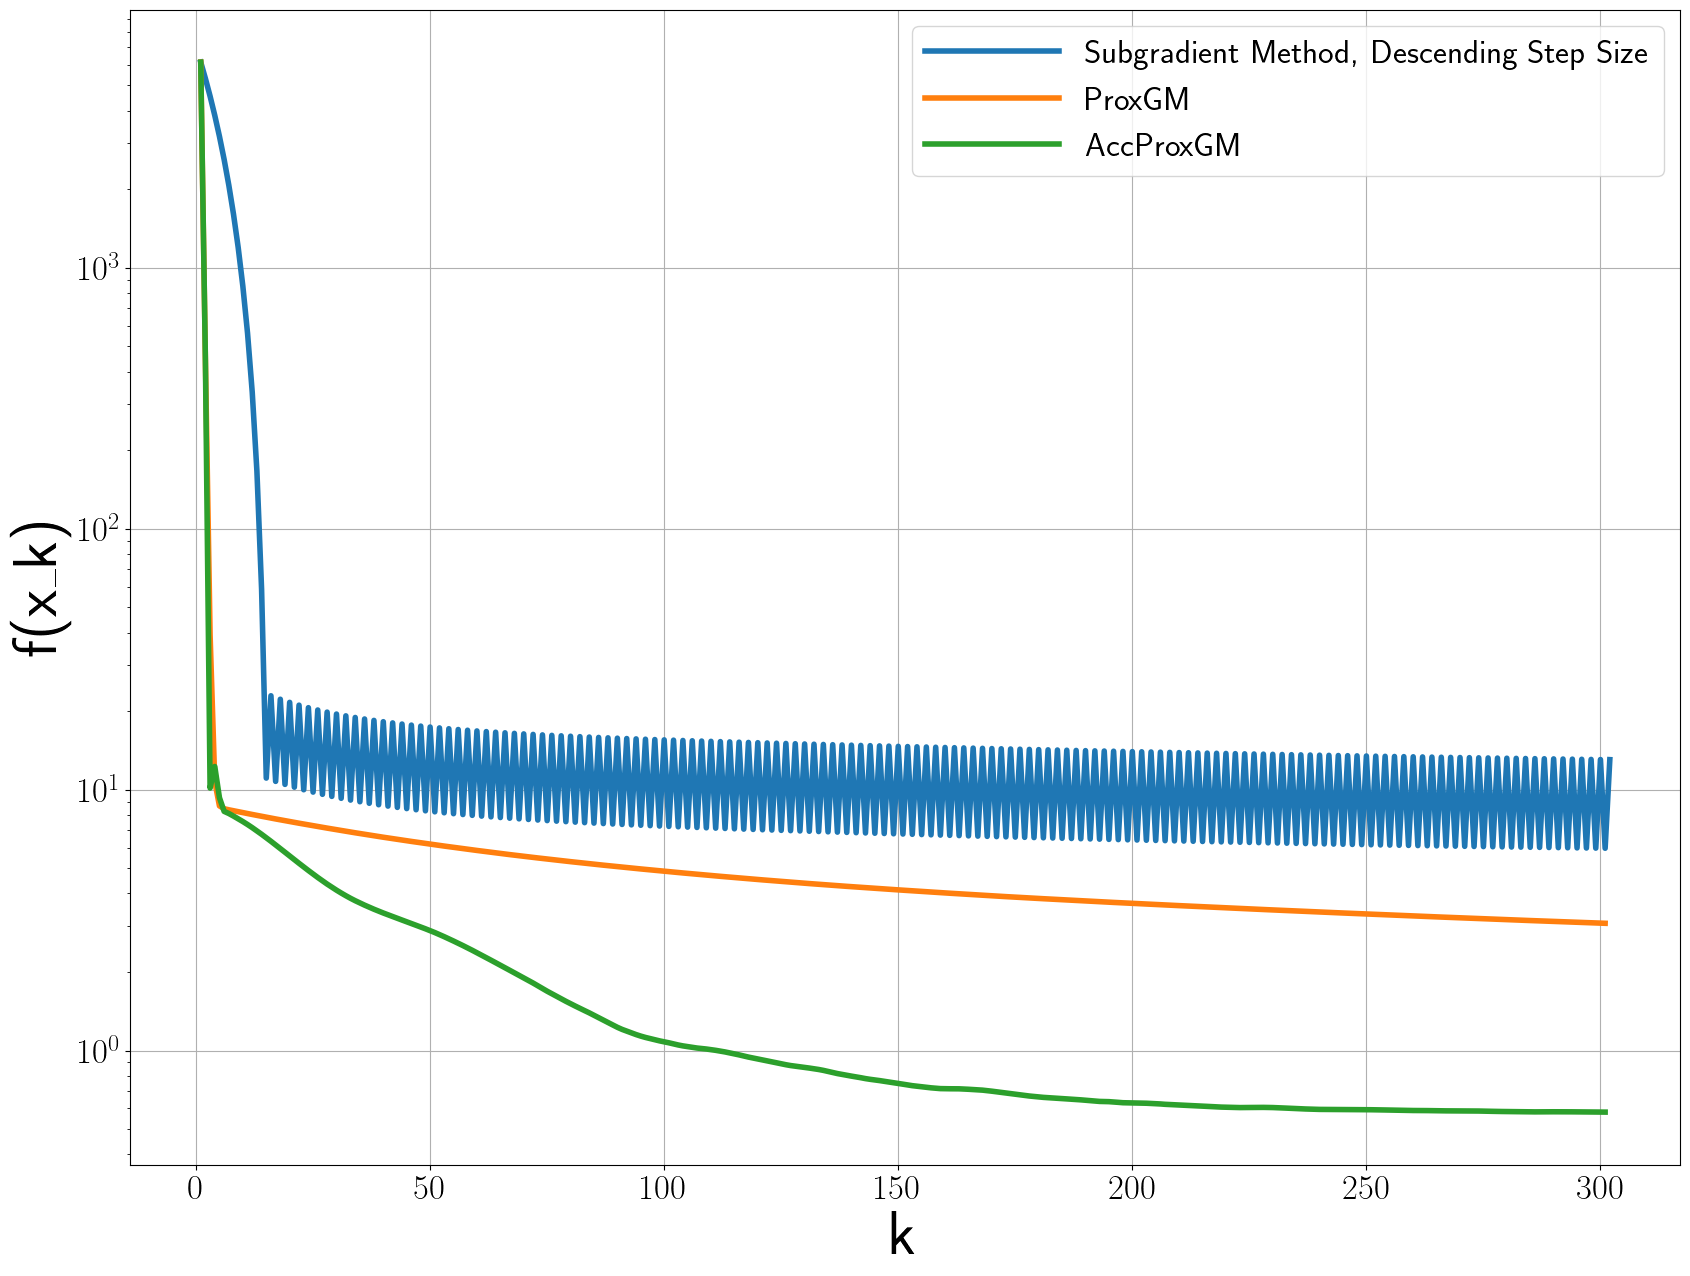

In [18]:
%matplotlib inline
plt.rc("text", usetex=True)
plt.figure(figsize=(20, 15))

for method in methods:
    hist = [F_composite(x) for x, _ in method.history]
    plt.semilogy(range(1, len(hist) + 1), hist, label=method.name)
plt.grid()
plt.xlabel("k")
plt.ylabel("f(x_k)")
plt.legend(loc="best", fontsize=24);

Теперь решим эту задачу методом FW. Но для данного алгоритма нужно ввести ограничения, для этого вынесем негладкое слагаемое $h(x)$ в ограничения:

$$
\begin{aligned}
\min_{\mathbf{x} \in Q} \quad & f(\mathbf{x}) = \frac{1}{2}\|Ax - y \|^2_2 \\
\text{s. t.} \quad &  \|x\|_1 \leq \gamma  \\
\end{aligned}
$$

In [19]:
def lmo_l1_ball(radius=1.0):
    def f(g):
        if np.all(g == 0):
            return np.zeros_like(g)
        j = np.argmax(np.abs(g))
        s = np.zeros_like(g)
        s[j] = -radius * np.sign(g[j])
        return s

    return lambda g: f(g)

class FW_alg:
    def __init__(self, StepSizeChoice, lmo, return_history=True, name=None):
        self.name = name
        self.StepSizeChoice = StepSizeChoice
        self.return_history = return_history
        self.lmo = lmo
        self.history = []

    def __call__(self, x0, f, gradf, N):
        assert True, 'Please call solve method.'
    
    def solve(self, x0, f, gradf, tol=1e-9, max_iter=10000):
        x = x0.copy()
        self.history = [(x0, time.time())]
        for k in range(max_iters):
            g = gradf(x)
            s = self.lmo(g)
            alpha = self.StepSizeChoice(x, g, k, gradf, f)
            assert 0 <= alpha <= 1, f"alpha = {alpha}"
            x = x + alpha * (s - x)
            if np.linalg.norm(x - self.history[-1][0]) < tol and not k == 0:
                print("Function value did not decrease significantly.")
                break
            self.history.append((x, time.time()))
        return x

In [20]:
max_iters = 300
methods = []

method = SubgradMethod(ConstantStepSize(np.linalg.norm(x0 - x_true) / np.sqrt(max_iters + 1)), 
                       name="Subgradient Method, Descending Step Size")
x_subgrad = method.solve(x0, F_composite, subgradF_composite, max_iter=max_iters)
methods.append(method)
print(method.name)
print("\tNumber nonzeros in x* = {}".format(np.sum(x_subgrad != 0)))
print("\tf^* = {}".format(F_composite(x_subgrad)))

method = ProxGM(name="ProxGM")
x = method.solve(x0, f, gradf, g_prox, tol=1e-9, max_iter=max_iters)
methods.append(method)
print(method.name)
print("\tNumber nonzeros in x* = {}".format(np.sum(x != 0)))
print("\tf* = {}".format(F_composite(x)))

method = AccProxGM(name="AccProxGM")
x_acc = method.solve(x0, f, gradf, g_prox, tol=1e-9, max_iter=max_iters)
methods.append(method)
print(method.name)
print("\tNumber nonzeros in x* = {}".format(np.sum(x_acc != 0)))
print("\tf* = {}".format(F_composite(x_acc)))

method = FW_alg(SeqStepSize(1.0), lmo_l1_ball(radius=5.0), 
                name="FW, descending step size")
x_acc = method.solve(x0, f, gradf, tol=1e-9, max_iter=max_iters)
methods.append(method)
print(method.name)
print("\tNumber nonzeros in x* = {}".format(np.sum(x_acc != 0)))
print("\tf* = {}".format(F_composite(x_acc)))

Subgradient Method, Descending Step Size
	Number nonzeros in x* = 250
	f^* = 13.029050734102915
ProxGM
	Number nonzeros in x* = 220
	f* = 3.0736084763734346
AccProxGM
	Number nonzeros in x* = 37
	f* = 0.5806382448900493
FW, descending step size
	Number nonzeros in x* = 18
	f* = 0.5966941406852894


Сравним предыдущие методы с методом Франк-Вульфа. Заметим в очередной раз, что алгоритм имеет превосходную способность искать разреженные решения.

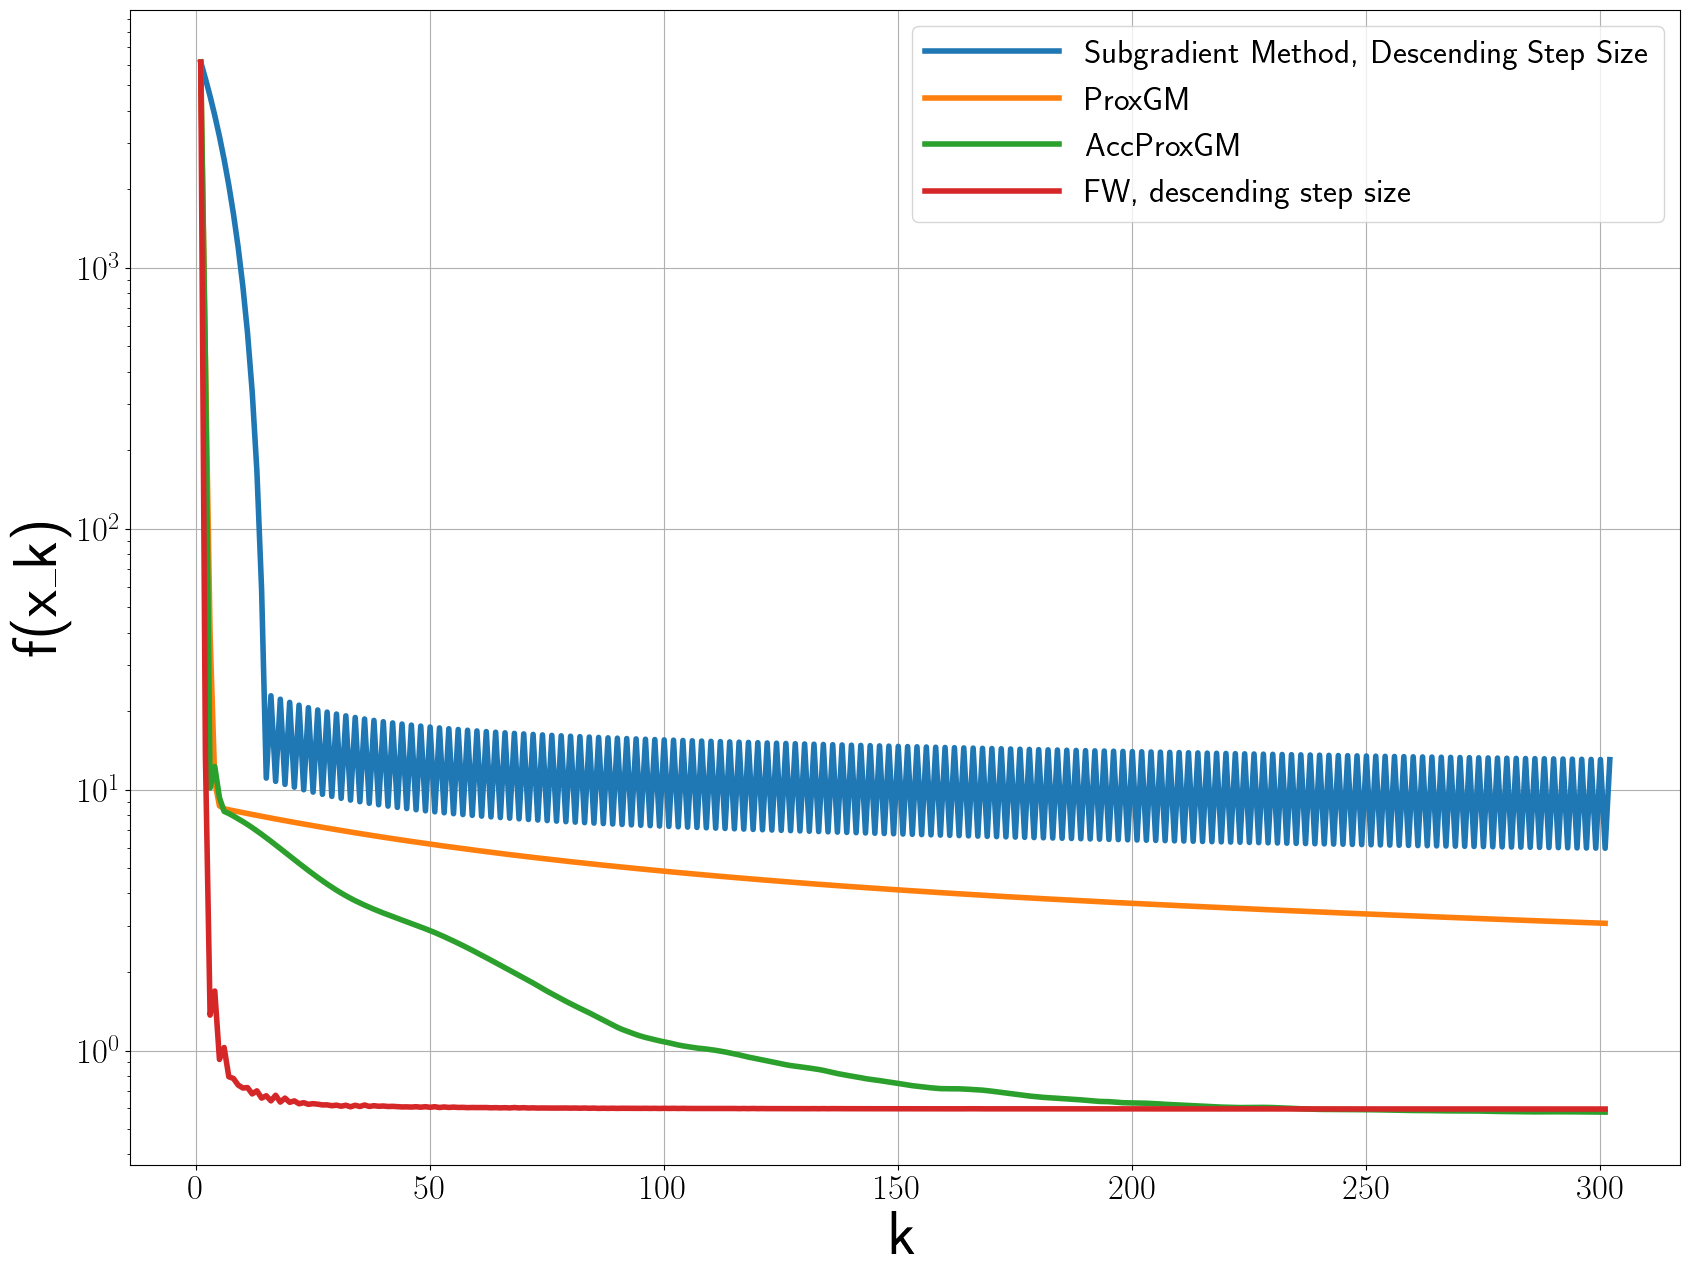

In [21]:
%matplotlib inline
plt.rc("text", usetex=True)
plt.figure(figsize=(20, 15))

for method in methods:
    hist = [F_composite(x) for x, _ in method.history]
    plt.semilogy(range(1, len(hist) + 1), hist, label=method.name)
plt.grid()
plt.xlabel("k")
plt.ylabel("f(x_k)")
plt.legend(loc="best", fontsize=24);

Далее сравним алгоритмы по времени выполнения

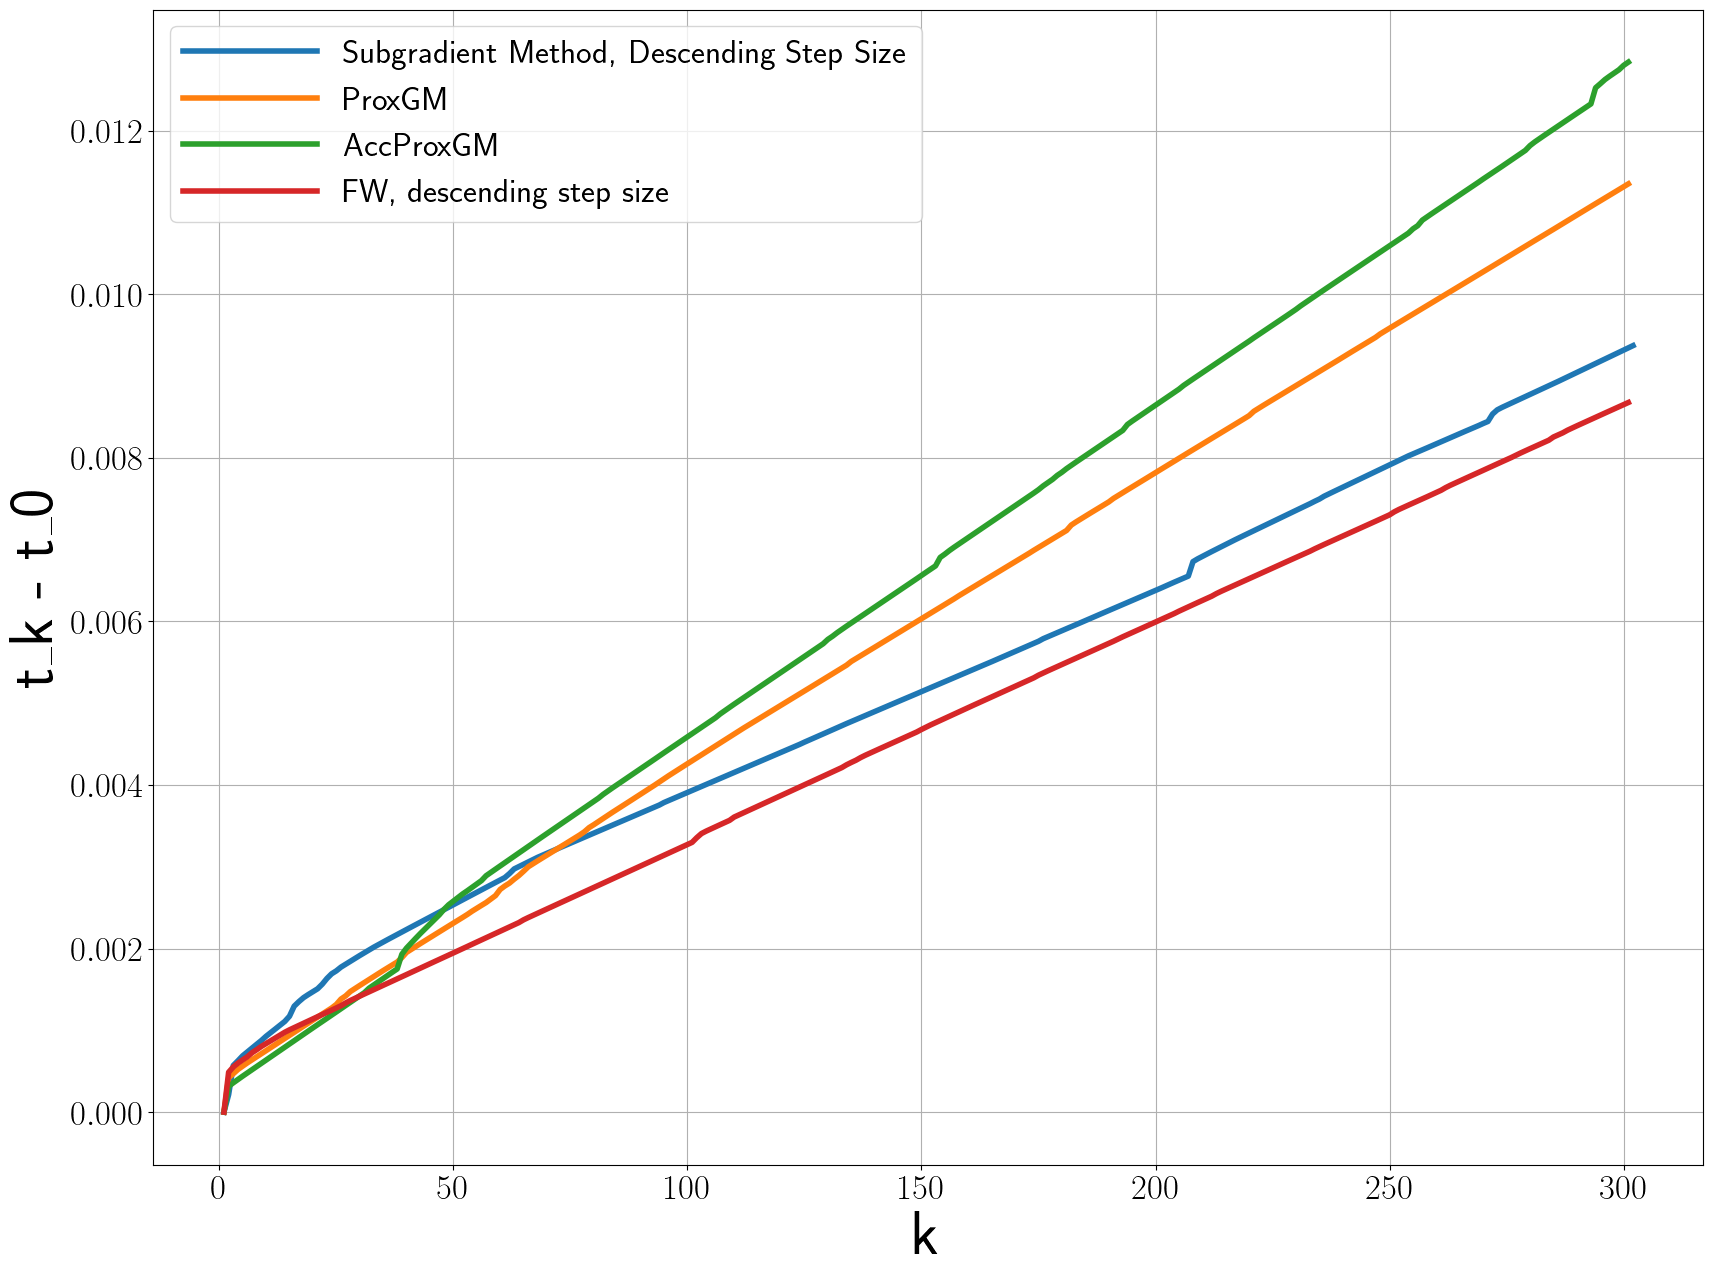

In [22]:
%matplotlib inline
plt.rc("text", usetex=True)
plt.figure(figsize=(20, 15))

for method in methods:
    hist = [time for _, time in method.history]
    hist = np.array(hist)
    hist -= hist[0]
    plt.plot(range(1, len(hist) + 1), hist, label=method.name)
plt.grid()
plt.xlabel("k")
plt.ylabel("t_k - t_0")
plt.legend(loc="best", fontsize=24);

Замерим поведение субградиентного, проксимального и ускоренного проксимального методов на разных коэффициентах регуляризации $\gamma$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

max_iters = 500
gammas = np.logspace(-3, 0, 4)

results = []

for gamma in gammas:
    print(f"\n=== Running for gamma = {gamma:.3e} ===")
    methods = []

    # Define composite function and its parts
    F_composite = lambda x: np.linalg.norm(A.dot(x) - y) ** 2 / 2 + gamma * np.sum(np.abs(x))
    subgradF_composite = lambda x: A.T.dot(A.dot(x) - y) + gamma * np.sign(x)

    f = lambda x: np.linalg.norm(A.dot(x) - y) ** 2 / 2
    gradf = lambda x: A.T.dot(A.dot(x) - y)
    g_prox = lambda h, alpha: np.sign(h) * np.maximum(np.abs(h) - alpha * gamma, 0)

    # Subgradient method
    method = SubgradMethod(ConstantStepSize(np.linalg.norm(x0 - x_true) / np.sqrt(max_iters + 1)),
                           name="Subgradient Method")
    x_subgrad = method.solve(x0, F_composite, subgradF_composite, max_iter=max_iters)
    methods.append(method)
    print(method.name, "nonzeros:", np.sum(x_subgrad != 0), "f* =", F_composite(x_subgrad))

    # Proximal Gradient
    method = ProxGM(name="ProxGM")
    x_prox = method.solve(x0, f, gradf, g_prox, tol=1e-9, max_iter=max_iters)
    methods.append(method)
    print(method.name, "nonzeros:", np.sum(x_prox != 0), "f* =", F_composite(x_prox))

    # Accelerated Proximal Gradient
    method = AccProxGM(name="AccProxGM")
    x_acc = method.solve(x0, f, gradf, g_prox, tol=1e-9, max_iter=max_iters)
    methods.append(method)
    print(method.name, "nonzeros:", np.sum(x_acc != 0), "f* =", F_composite(x_acc))

    # Frank-Wolfe
    # method = FW_alg(SeqStepSize(1.0), lmo_l1_ball(radius=5.0), name="Frank-Wolfe")
    # x_fw = method.solve(x0, f, gradf, tol=1e-9, max_iter=max_iters)
    # methods.append(method)
    # print(method.name, "nonzeros:", np.sum(x_fw != 0), "f* =", F_composite(x_fw))

    results.append((gamma, methods, F_composite))



=== Running for gamma = 1.000e-03 ===
Subgradient Method nonzeros: 250 f* = 5.264205571414484
ProxGM nonzeros: 250 f* = 0.09901455010663004
AccProxGM nonzeros: 248 f* = 0.03612124746411912

=== Running for gamma = 1.000e-02 ===
Subgradient Method nonzeros: 250 f* = 5.680768859059431
ProxGM nonzeros: 249 f* = 0.5839088642689447
AccProxGM nonzeros: 186 f* = 0.11914707643597751

=== Running for gamma = 1.000e-01 ===
Subgradient Method nonzeros: 250 f* = 5.914295131524479
ProxGM nonzeros: 164 f* = 2.4132651133188556
AccProxGM nonzeros: 19 f* = 0.7409992061560309

=== Running for gamma = 1.000e+00 ===
Subgradient Method nonzeros: 250 f* = 8.477131458566078
ProxGM nonzeros: 0 f* = 1.3663418760494785
AccProxGM nonzeros: 0 f* = 1.3663418760494785


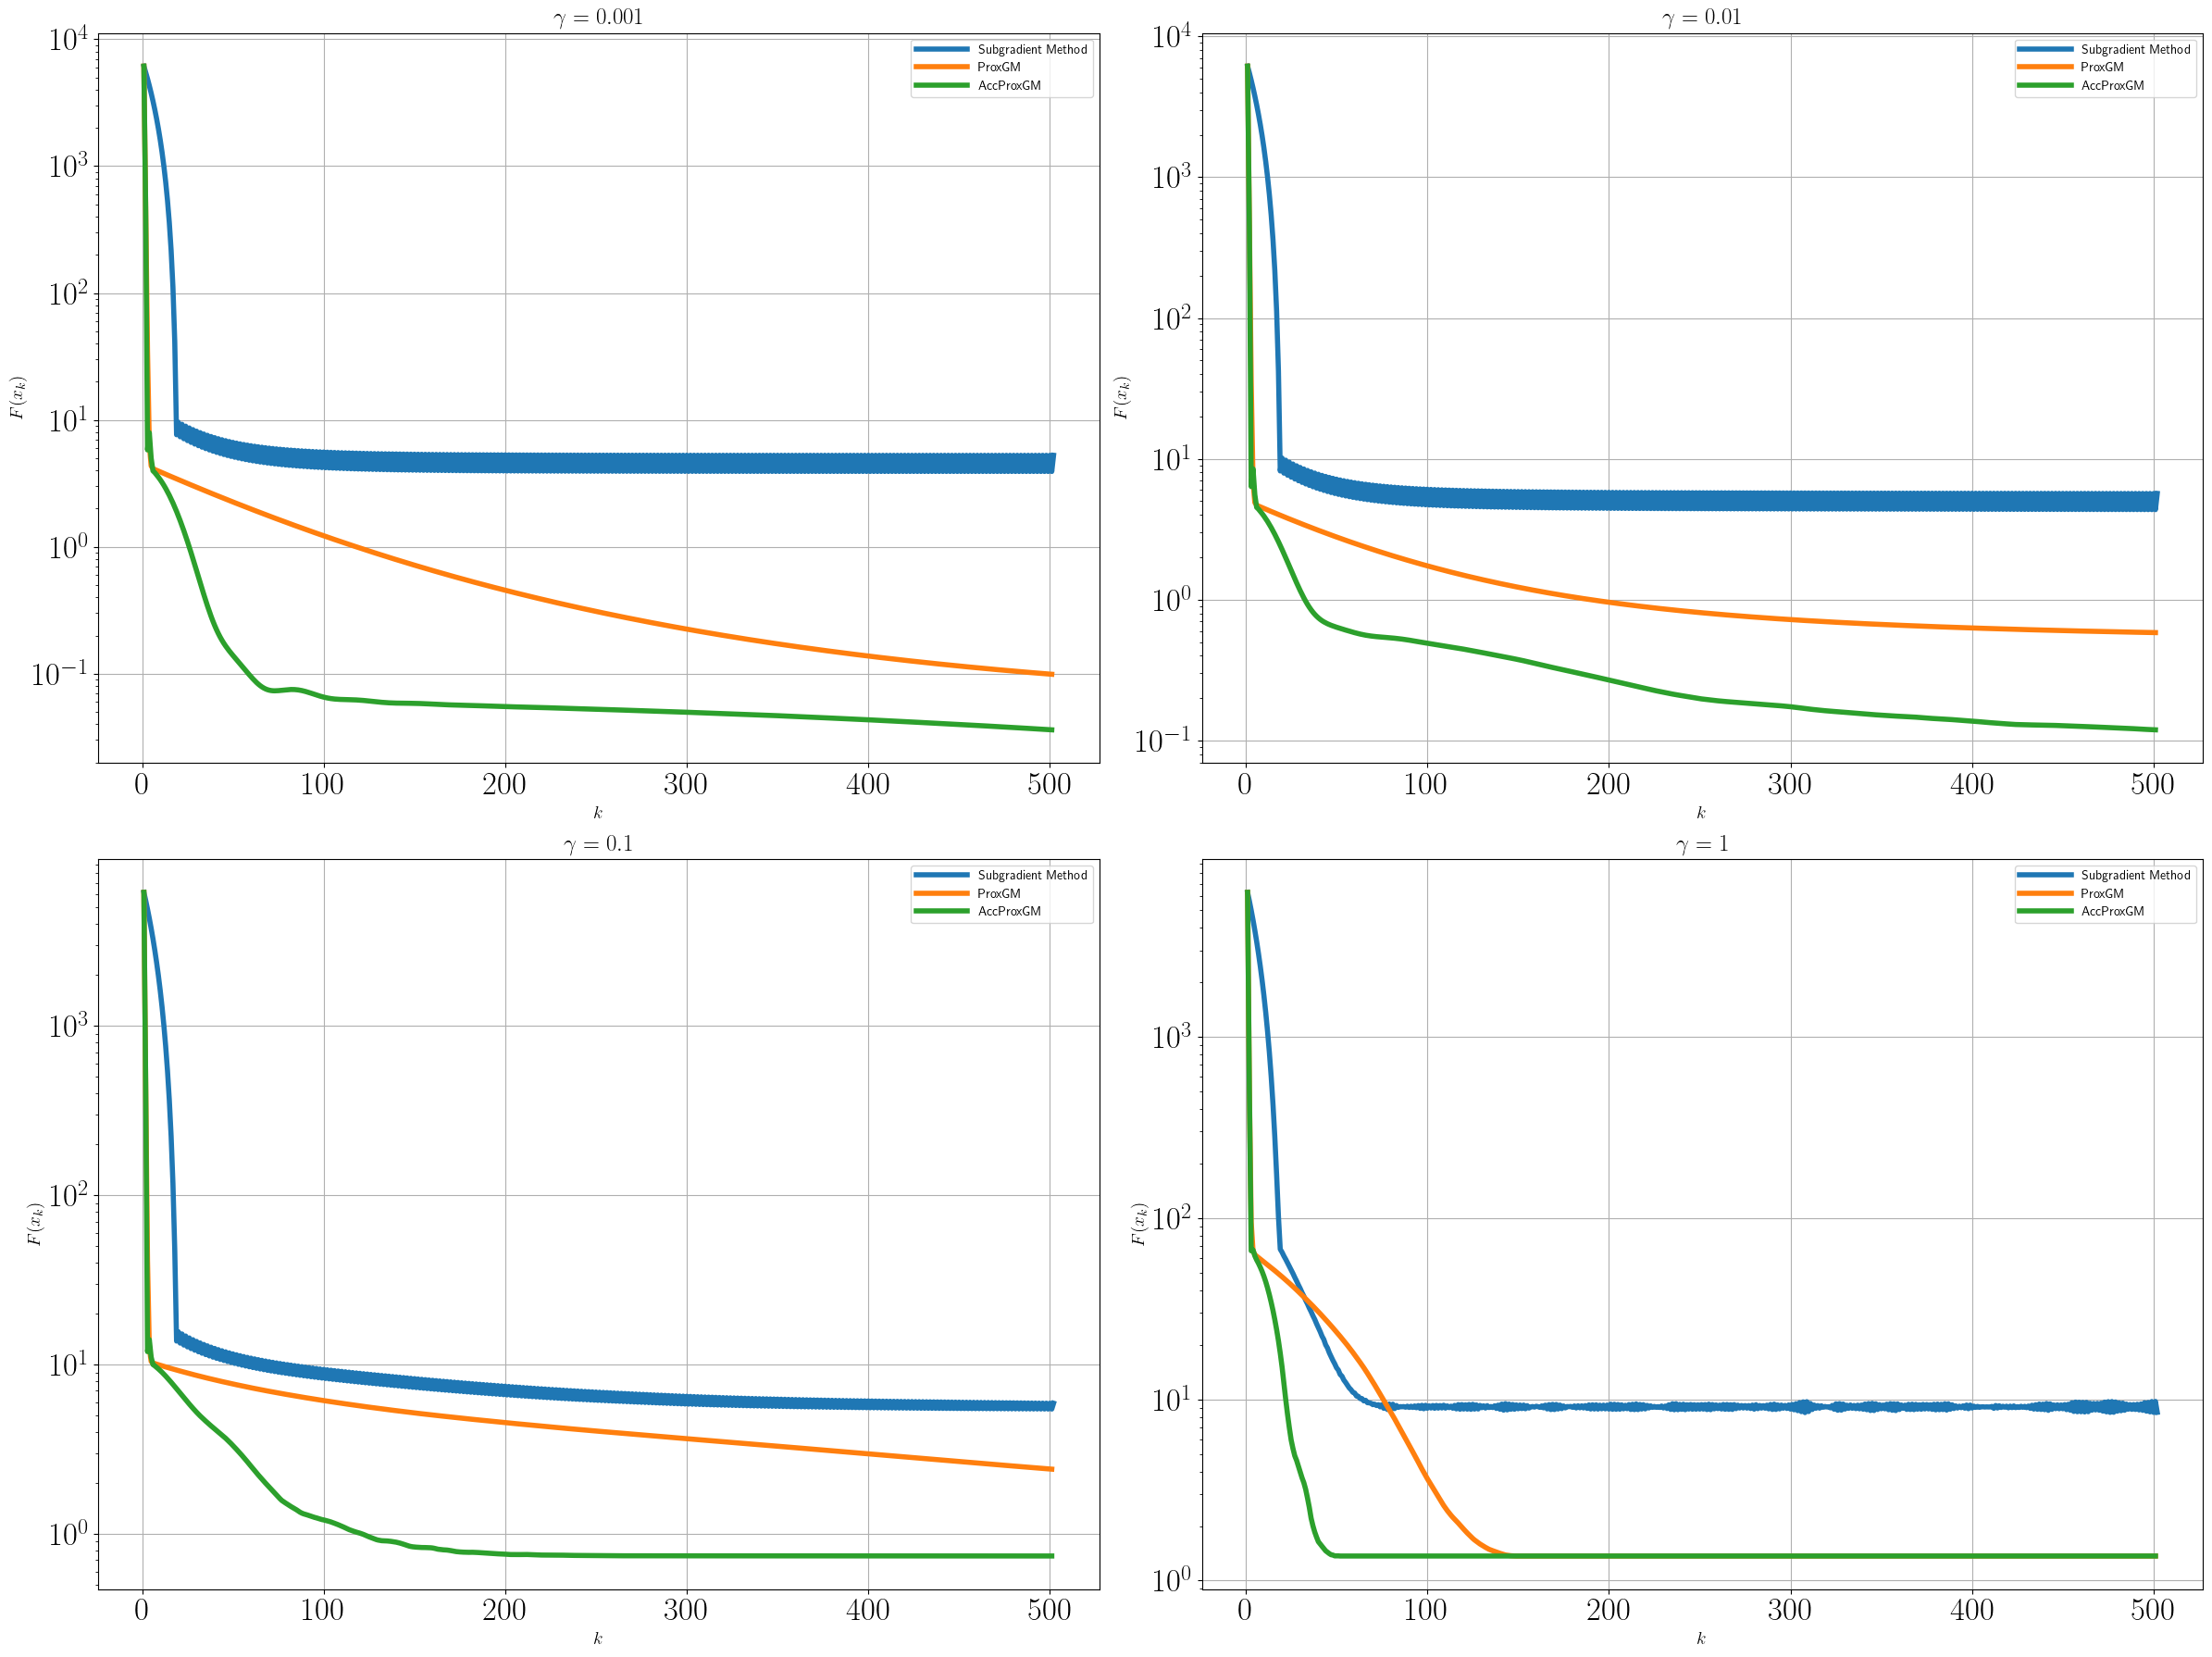

In [28]:
plt.rc("text", usetex=True)
plt.figure(figsize=(24, 18))

for i, (gamma, methods, F_composite) in enumerate(results, 1):
    plt.subplot(2, 2, i)
    for method in methods:
        hist = [F_composite(x) for x, _ in method.history]
        plt.semilogy(range(1, len(hist) + 1), hist, label=method.name)
    plt.grid()
    plt.xlabel(r"$k$", fontsize=14)
    plt.ylabel(r"$F(x_k)$", fontsize=14)
    plt.title(fr"$\gamma = {gamma:.3g}$", fontsize=18)
    plt.legend(fontsize=10, loc="best")

plt.tight_layout()
plt.show()


Теперь пронаблюдаем поведение алгоритма FW при изменении радиуса.

In [46]:
import numpy as np
import matplotlib.pyplot as plt

max_iters = 150
# radii = np.logspace(-2, 2, 4) 
radii = [8, 10, 20, 50]
results_fw = []

for radius in radii:
    print(f"\n=== Running for radius = {radius:.3e} ===")

    method = FW_alg(SeqStepSize(1.0), lmo_l1_ball(radius=radius),
                    name=f"Frank-Wolfe, R={radius:.2g}")
    x_fw = method.solve(x0, f, gradf, tol=1e-9, max_iter=max_iters)

    print(method.name)
    print("\tNumber nonzeros =", np.sum(x_fw != 0))
    print("\tf* =", f(x_fw))

    results_fw.append((radius, method, f))


=== Running for radius = 8.000e+00 ===
Frank-Wolfe, R=8
	Number nonzeros = 32
	f* = 0.04841597152077662

=== Running for radius = 1.000e+01 ===
Frank-Wolfe, R=10
	Number nonzeros = 50
	f* = 0.011785568808299327

=== Running for radius = 2.000e+01 ===
Frank-Wolfe, R=20
	Number nonzeros = 83
	f* = 0.009642157951070434

=== Running for radius = 5.000e+01 ===
Frank-Wolfe, R=50
	Number nonzeros = 55
	f* = 0.05536237104567304


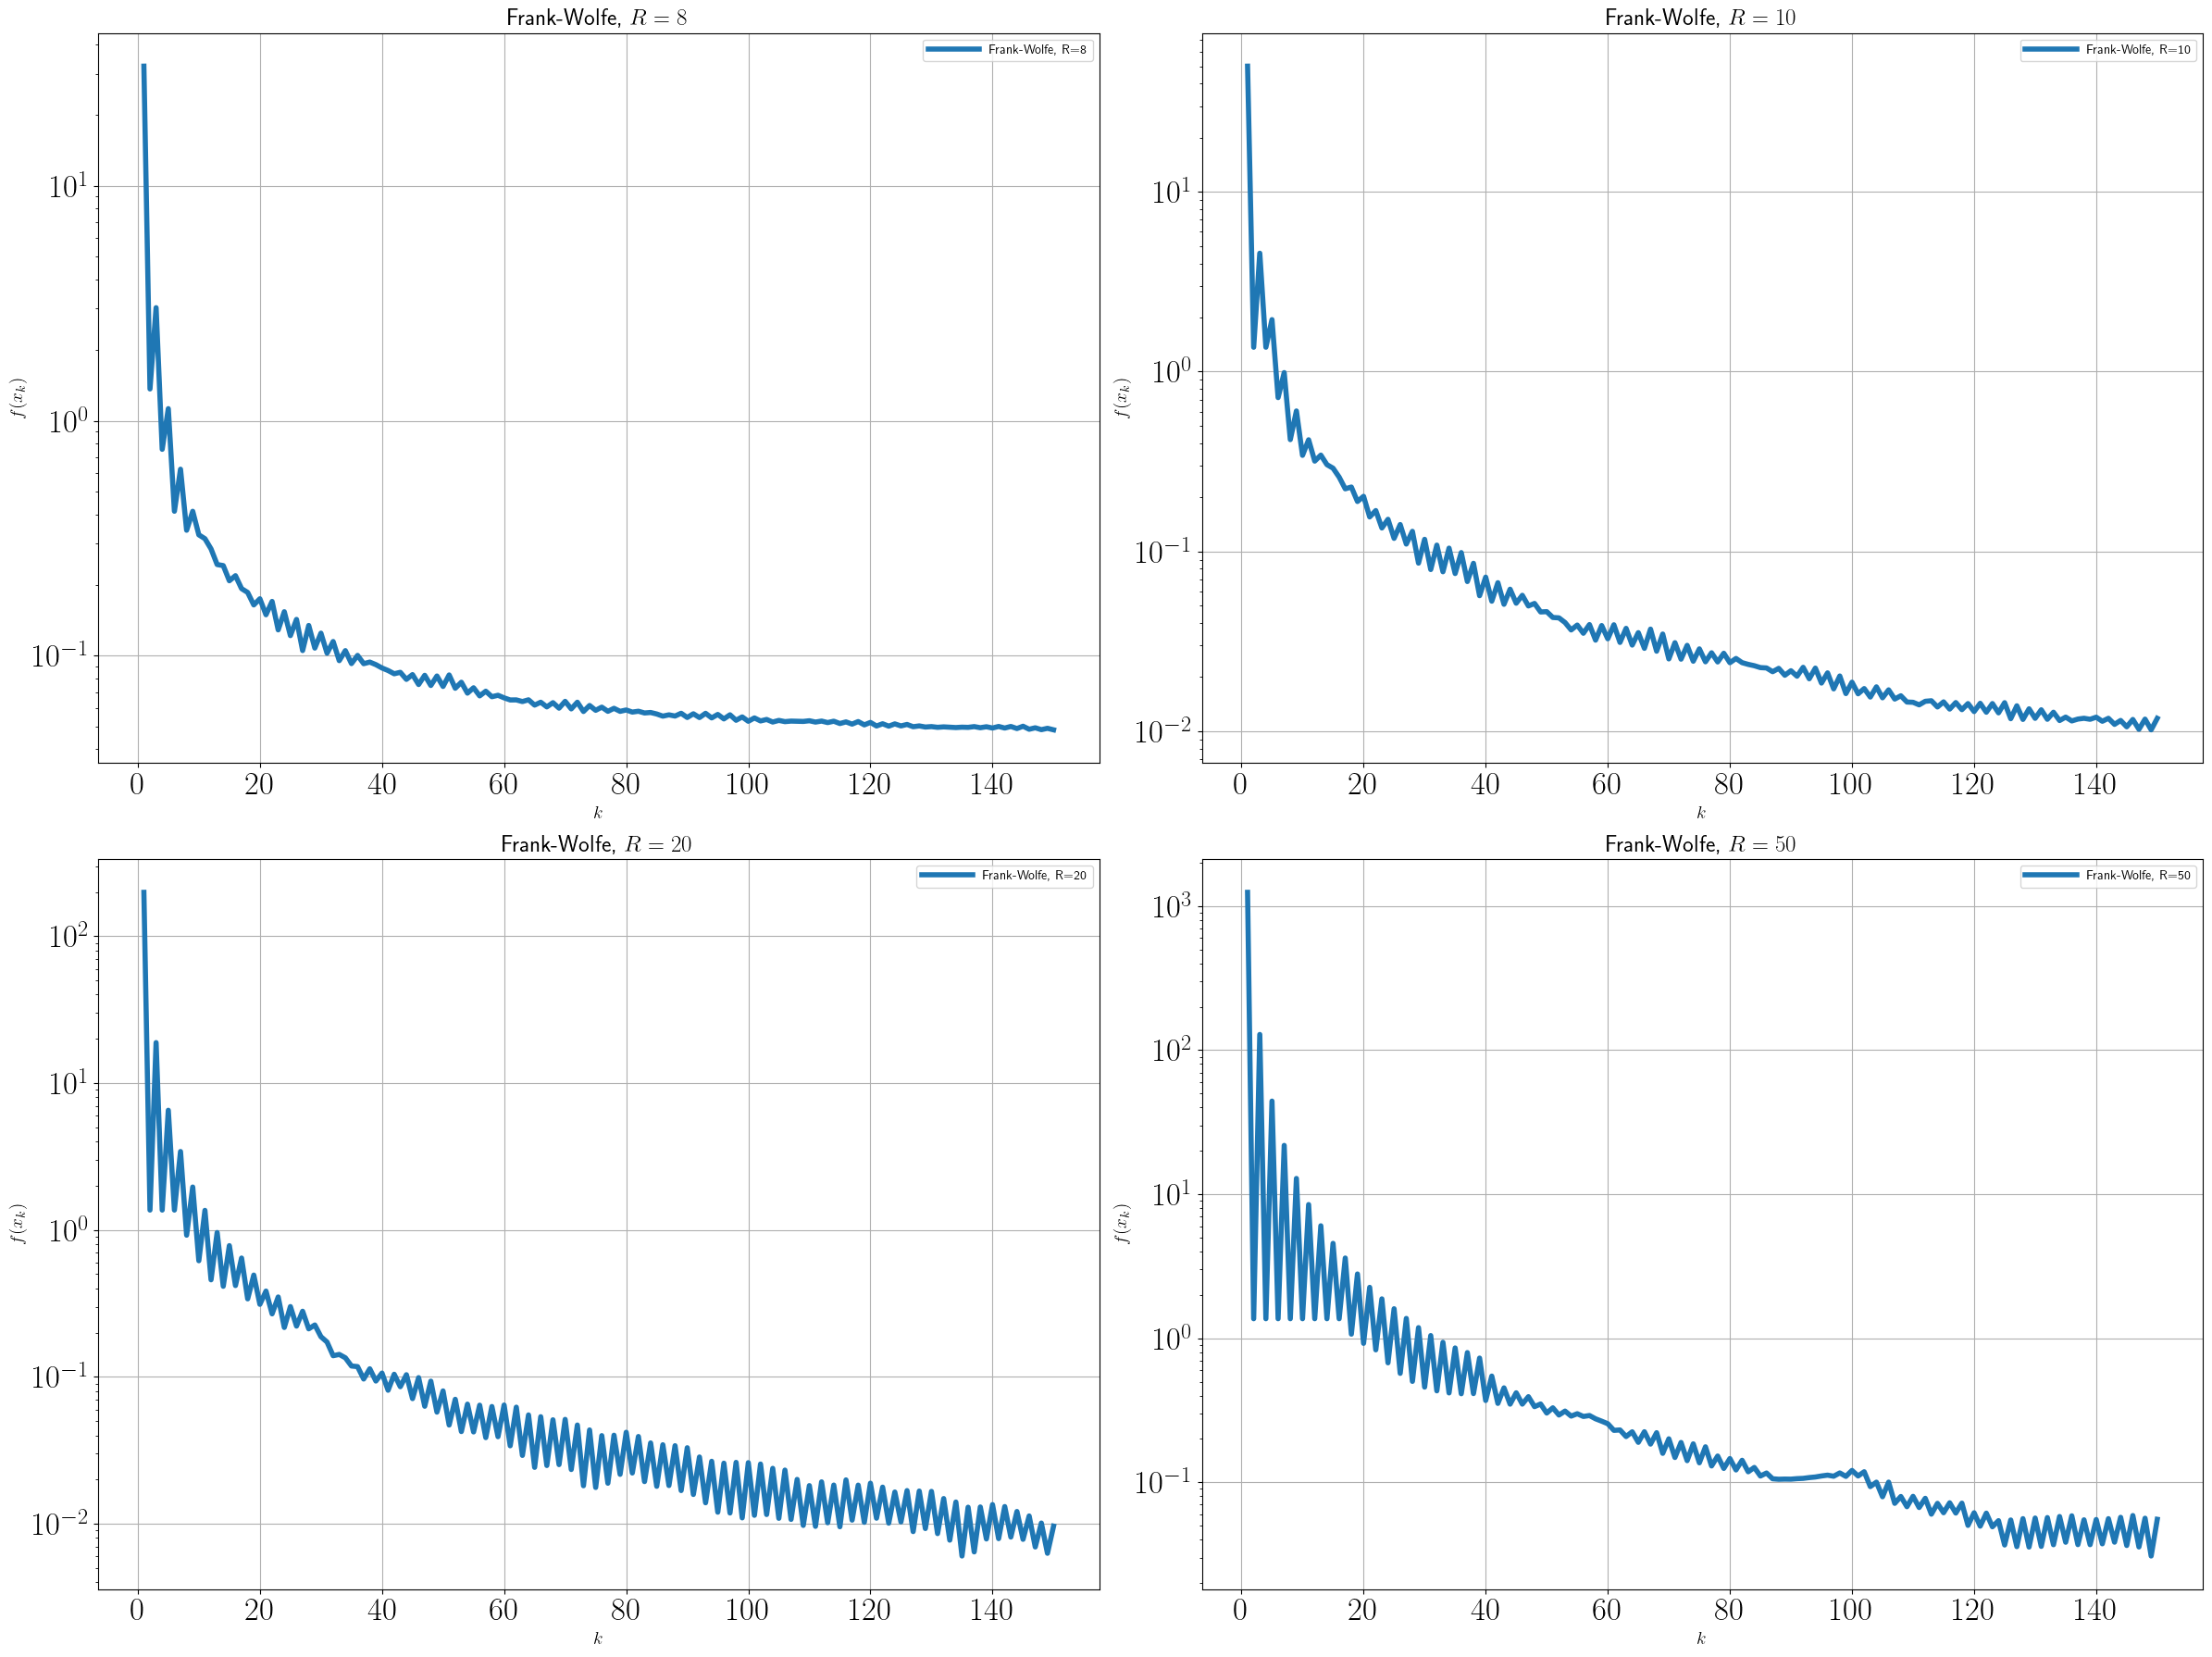

In [47]:
plt.rc("text", usetex=True)
plt.figure(figsize=(24, 18))

x_true_radius = np.linalg.norm(x_true, ord=1)

for i, (radius, method, f) in enumerate(results_fw, 1):
    plt.subplot(2, 2, i)
    hist = [f(x) for x, _ in method.history]
    plt.semilogy(range(1, len(hist)), hist[1:], label=method.name)
    plt.grid()
    plt.xlabel(r"$k$", fontsize=14)
    plt.ylabel(r"$f(x_k)$", fontsize=14)
    plt.title(fr"Frank-Wolfe, $R = {radius:.3g}$", fontsize=18)
    plt.legend(fontsize=10, loc="best")

plt.tight_layout()
plt.show()

## Эксперименты с адаптивным подбором параметров

Что даёт адаптивность? Если нам неизвестна $L$, то мы можем искать константу $L$ на каждой итерации (тут $L = 1 / \alpha$):

$$h(x_{k+1})\leq h(x_k) + \langle \nabla h_k, x_{k+1}-x_k \rangle + \frac{1}{2\alpha}\|x_k-x_{k+1}\|^2$$

__Примечание__ Скорость сходимости $\mathcal{O}(1/k)$ для шага $\alpha_k \equiv \alpha \in (0, 1/L]$, где $L$ - константа Липшица градиента $h'$ (стандартная для выпуклой оптимизации лемма, см. например, Ю.Е. Нестеров "Введение в выпуклую оптимизацию", с. 47)

Сравним методы с постоянными шагами и с адаптивным

In [ ]:
max_iters = 2000
methods = []

method = ProxGM(name="ProxGM, adapt")
x = method.solve(x0, f, gradf, g_prox, max_iter=max_iters)
methods.append(method)
print(method.name)
print("\tNumber nonzeros in x* = {}".format(np.sum(x != 0)))
print("\tf* = {}".format(F_composite(x)))

method = ProxGM(name="ProxGM, 2/L", fix_lam=2.1/L)
x = method.solve(x0, f, gradf, g_prox, max_iter=max_iters)
methods.append(method)
print(method.name)
print("\tNumber nonzeros in x* = {}".format(np.sum(x != 0)))
print("\tf* = {}".format(F_composite(x)))

method = ProxGM(name="ProxGM, 1/2L", fix_lam=1/(2*L))
x = method.solve(x0, f, gradf, g_prox, max_iter=max_iters)
methods.append(method)
print(method.name)
print("\tNumber nonzeros in x* = {}".format(np.sum(x != 0)))
print("\tf* = {}".format(F_composite(x)))

ProxGM, adapt
	Number nonzeros in x* = 309
	f* = 26.164257420296543
ProxGM, 2/L
	Number nonzeros in x* = 2500
	f* = 2.046126292454048e+171
ProxGM, 1/2L
	Number nonzeros in x* = 439
	f* = 27.197129012666938


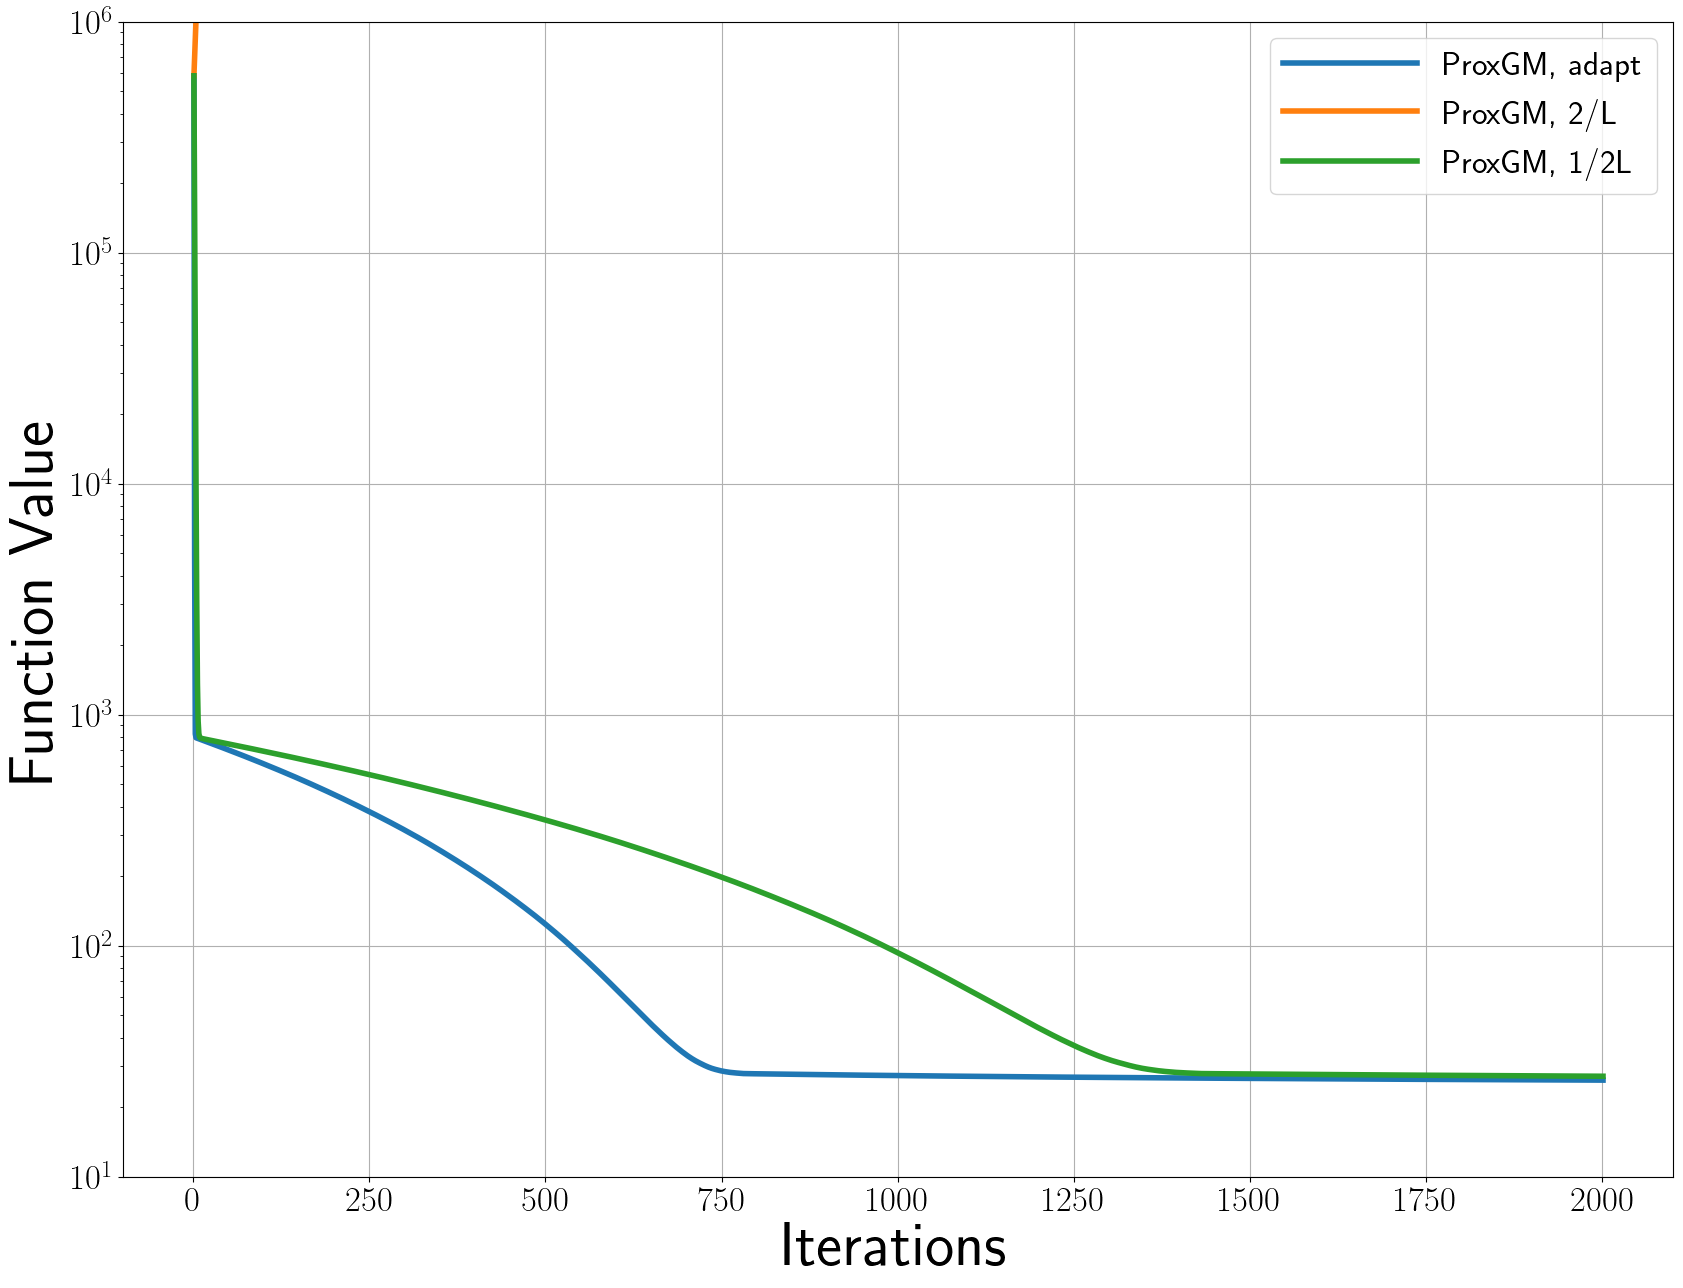

In [ ]:
%matplotlib inline
plt.rc("text", usetex=True)
plt.figure(figsize=(20, 15))

for method in methods:
    hist = [F_composite(x) for x, _ in method.history]
    plt.semilogy(range(1, len(hist) + 1), hist, label=method.name)
plt.grid()
plt.xlabel("Iterations")
plt.ylabel("Function Value")
plt.ylim((1e+1, 1e+6))
plt.legend(loc="best", fontsize=24);

Как видим, при неправильно подобранном шаге метод может расходиться. Адаптивность же позволяет предотвратить это